Importing libraries

1) For ML Models: Tensorflow, keras 
2) For Data Manipulation: numpy, pandas, sklearn 
3) For Data Visualization: matplotlib, seaborn

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

Reading the Dataset

In [2]:
train_dir = 'Training/'
test_dir = 'Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

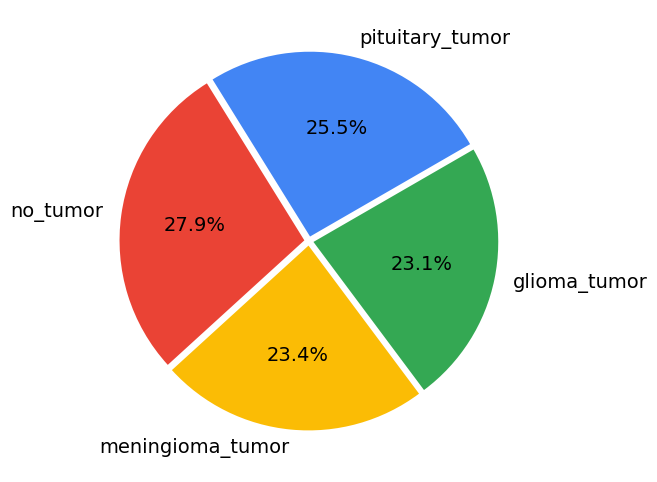

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary_tumor']),
         len([x for x in train_labels if x=='no_tumor']),
         len([x for x in train_labels if x=='meningioma_tumor']),
         len([x for x in train_labels if x=='glioma_tumor'])],
        labels=['pituitary_tumor','no_tumor', 'meningioma_tumor', 'glioma_tumor'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

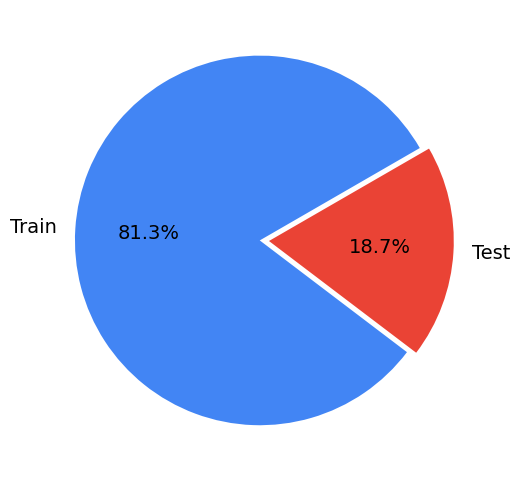

In [5]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

Data Augmentation

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    
    # Randomly flip the image horizontally
    if random.random() < 0.5:
        image = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    
    # Randomly zoom the image
    zoom_factor = random.uniform(0.8, 1.2)
    width, height = image.size
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    image = image.resize((new_width, new_height))
    
    # Center-crop the image back to its original size
    left = (new_width - width) // 2
    top = (new_height - height) // 2
    right = (new_width + width) // 2
    bottom = (new_height + height) // 2
    image = image.crop((left, top, right, bottom))
    
    image = np.array(image)/255.0
    return image

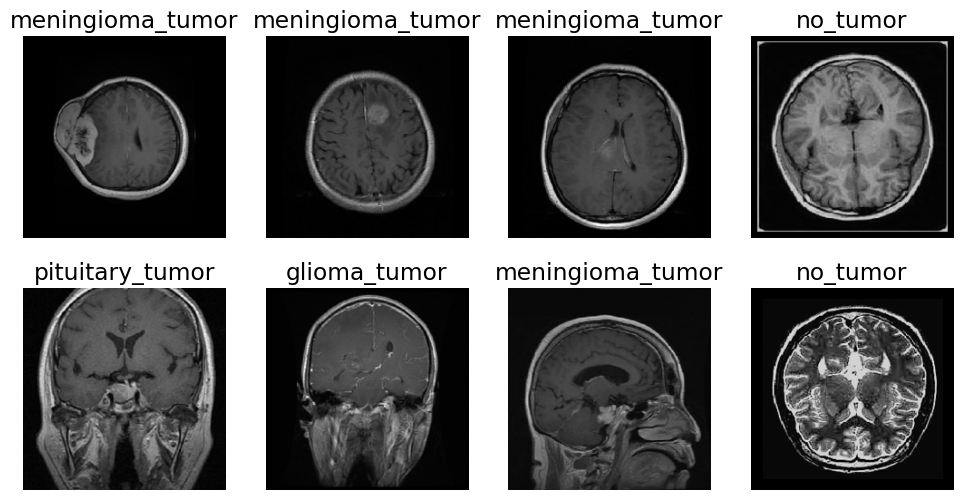

In [7]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

Data Generator

Given a list of paths to images, and the labels, this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on.

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=8):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

Model Building

In [9]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 10,291,332
No

In [11]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/8
285/285 [==============================] - 1208s 4s/step - loss: 0.2394 - accuracy: 0.9142
Epoch 2/8
285/285 [==============================] - 1130s 4s/step - loss: 0.1582 - accuracy: 0.9441
Epoch 3/8
285/285 [==============================] - 1066s 4s/step - loss: 0.1254 - accuracy: 0.9548
Epoch 4/8
285/285 [==============================] - 1081s 4s/step - loss: 0.0937 - accuracy: 0.9659
Epoch 5/8
285/285 [==============================] - 1180s 4s/step - loss: 0.0865 - accuracy: 0.9693
Epoch 6/8
285/285 [==============================] - 1111s 4s/step - loss: 0.0675 - accuracy: 0.9775
Epoch 7/8
285/285 [==============================] - 1126s 4s/step - loss: 0.0580 - accuracy: 0.9794
Epoch 8/8
285/285 [==============================] - 1124s 4s/step - loss: 0.0603 - accuracy: 0.9796


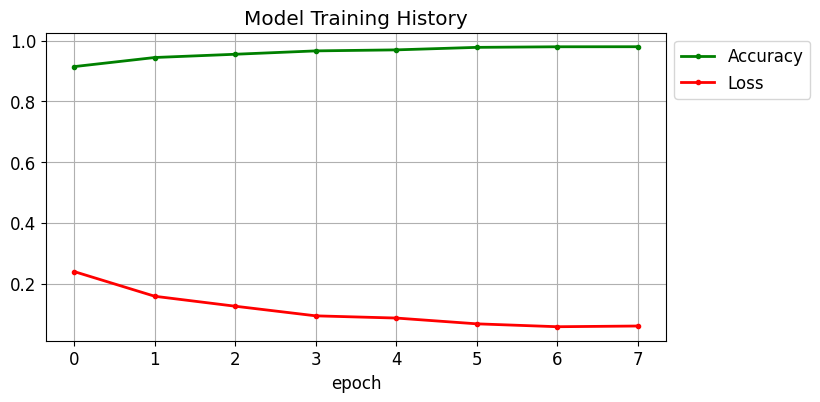

In [20]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Evaluate Model with Test Samples

In [21]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  2%|▎         | 1/40 [00:06<04:04,  6.28s/it]

1/1 [==============================] - 4s 4s/step


  5%|▌         | 2/40 [00:11<03:25,  5.40s/it]

1/1 [==============================] - 4s 4s/step


  8%|▊         | 3/40 [00:15<03:01,  4.91s/it]

1/1 [==============================] - 4s 4s/step


 10%|█         | 4/40 [00:19<02:51,  4.75s/it]

1/1 [==============================] - 5s 5s/step


 12%|█▎        | 5/40 [00:25<02:57,  5.07s/it]

1/1 [==============================] - 5s 5s/step


 15%|█▌        | 6/40 [00:30<02:56,  5.19s/it]

1/1 [==============================] - 5s 5s/step


 18%|█▊        | 7/40 [00:36<02:53,  5.25s/it]

1/1 [==============================] - 5s 5s/step


 20%|██        | 8/40 [00:41<02:50,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 22%|██▎       | 9/40 [00:47<02:46,  5.38s/it]

1/1 [==============================] - 5s 5s/step


 25%|██▌       | 10/40 [00:52<02:40,  5.34s/it]

1/1 [==============================] - 5s 5s/step


 28%|██▊       | 11/40 [00:57<02:34,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 30%|███       | 12/40 [01:03<02:29,  5.33s/it]

1/1 [==============================] - 5s 5s/step


 32%|███▎      | 13/40 [01:08<02:23,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 35%|███▌      | 14/40 [01:13<02:18,  5.34s/it]

1/1 [==============================] - 5s 5s/step


 38%|███▊      | 15/40 [01:19<02:13,  5.35s/it]

1/1 [==============================] - 5s 5s/step


 40%|████      | 16/40 [01:24<02:07,  5.31s/it]

1/1 [==============================] - 5s 5s/step


 42%|████▎     | 17/40 [01:29<02:01,  5.29s/it]

1/1 [==============================] - 5s 5s/step


 45%|████▌     | 18/40 [01:35<01:57,  5.35s/it]

1/1 [==============================] - 5s 5s/step


 48%|████▊     | 19/40 [01:40<01:53,  5.39s/it]

1/1 [==============================] - 5s 5s/step


 50%|█████     | 20/40 [01:45<01:47,  5.37s/it]

1/1 [==============================] - 5s 5s/step


 52%|█████▎    | 21/40 [01:51<01:41,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 55%|█████▌    | 22/40 [01:56<01:35,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 57%|█████▊    | 23/40 [02:01<01:30,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 60%|██████    | 24/40 [02:07<01:24,  5.31s/it]

1/1 [==============================] - 5s 5s/step


 62%|██████▎   | 25/40 [02:12<01:19,  5.32s/it]

1/1 [==============================] - 5s 5s/step


 65%|██████▌   | 26/40 [02:17<01:15,  5.36s/it]

1/1 [==============================] - 5s 5s/step


 68%|██████▊   | 27/40 [02:23<01:10,  5.40s/it]

1/1 [==============================] - 5s 5s/step


 70%|███████   | 28/40 [02:28<01:04,  5.37s/it]

1/1 [==============================] - 5s 5s/step


 72%|███████▎  | 29/40 [02:34<00:58,  5.35s/it]

1/1 [==============================] - 5s 5s/step


 75%|███████▌  | 30/40 [02:39<00:53,  5.37s/it]

1/1 [==============================] - 5s 5s/step


 78%|███████▊  | 31/40 [02:44<00:48,  5.42s/it]

1/1 [==============================] - 5s 5s/step


 80%|████████  | 32/40 [02:50<00:43,  5.40s/it]

1/1 [==============================] - 5s 5s/step


 82%|████████▎ | 33/40 [02:55<00:37,  5.39s/it]

1/1 [==============================] - 5s 5s/step


 85%|████████▌ | 34/40 [03:01<00:32,  5.42s/it]

1/1 [==============================] - 5s 5s/step


 88%|████████▊ | 35/40 [03:06<00:27,  5.44s/it]

1/1 [==============================] - 5s 5s/step


 90%|█████████ | 36/40 [03:11<00:21,  5.38s/it]

1/1 [==============================] - 5s 5s/step


 92%|█████████▎| 37/40 [03:17<00:16,  5.38s/it]

1/1 [==============================] - 5s 5s/step


 95%|█████████▌| 38/40 [03:22<00:10,  5.38s/it]

1/1 [==============================] - 5s 5s/step


 98%|█████████▊| 39/40 [03:27<00:05,  5.37s/it]

1/1 [==============================] - 5s 5s/step


100%|██████████| 40/40 [03:33<00:00,  5.38s/it]

1/1 [==============================] - 5s 5s/step


41it [03:38,  5.33s/it]                        


In [22]:
batch_size = 32
steps = int(len(test_paths)/batch_size)

test_gen = datagen(test_paths, test_labels, batch_size=batch_size)

scores = model.evaluate(test_gen, steps=steps)

40/40 [==============================] - 189s 5s/step - loss: 0.1245 - accuracy: 0.9617


In [23]:
print(classification_report(y_true, y_pred))

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.94      0.96       300
meningioma_tumor       0.94      0.88      0.91       306
        no_tumor       0.97      1.00      0.99       405
 pituitary_tumor       0.93      1.00      0.96       300

        accuracy                           0.96      1311
       macro avg       0.96      0.95      0.95      1311
    weighted avg       0.96      0.96      0.96      1311



In [24]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "testing",
    seed=12,
    shuffle=True,
    image_size=([IMAGE_SIZE,IMAGE_SIZE]),
    batch_size=32
)

Found 1311 files belonging to 4 classes.


In [25]:
class_names = dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 173ms/step


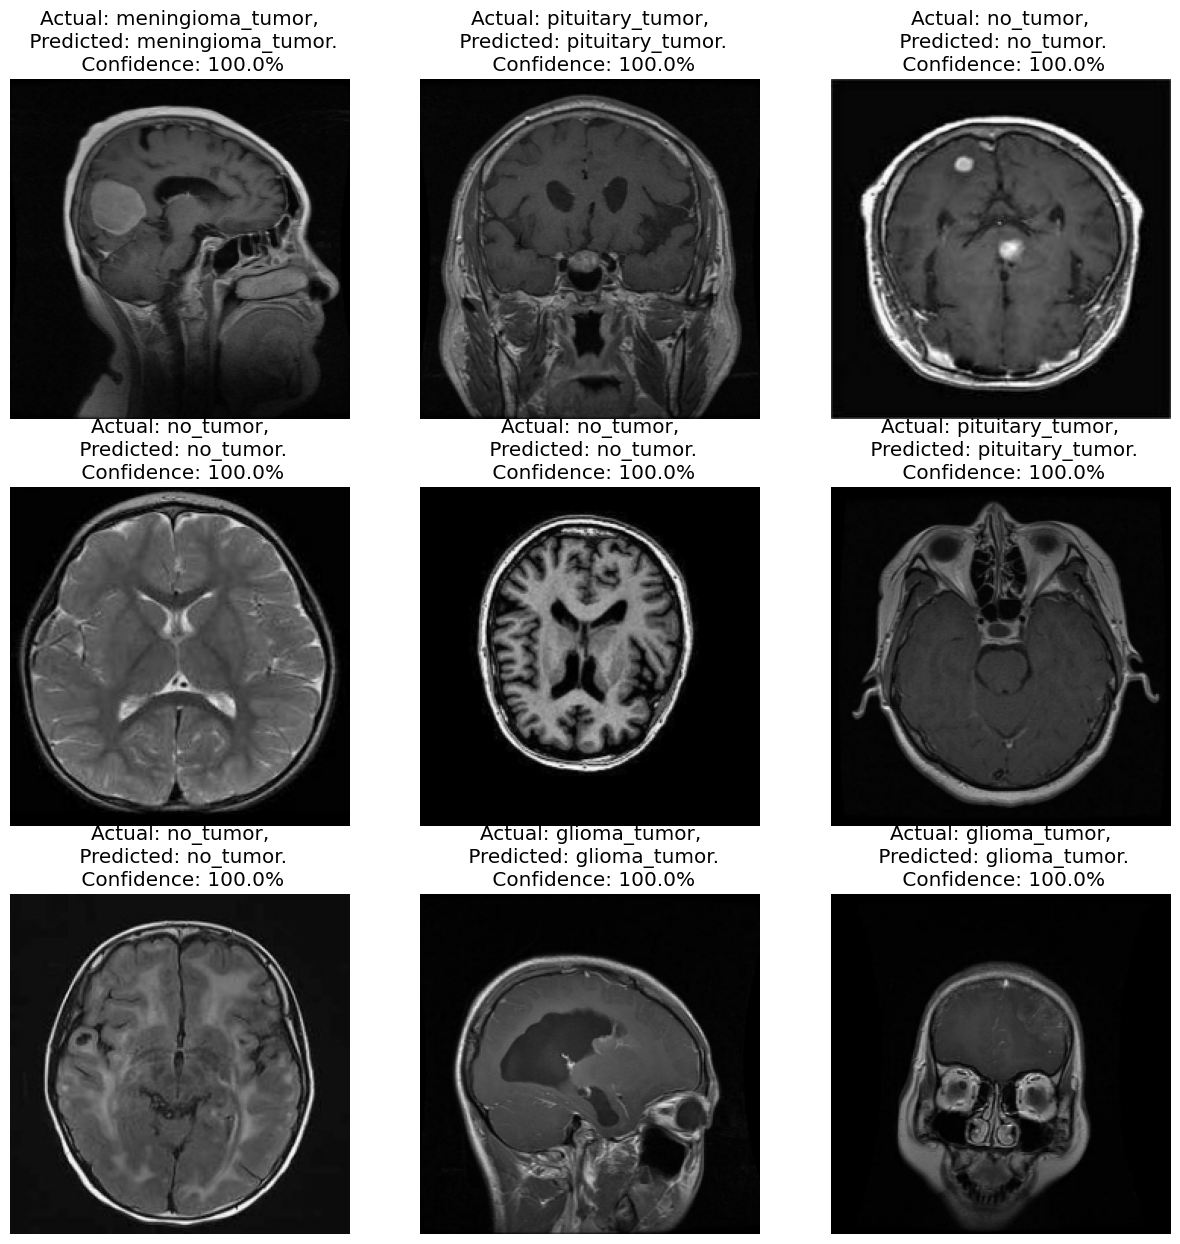

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

first image to predict
actual label: no_tumor
1/1 [==============================] - 4s 4s/step
predicted label: no_tumor


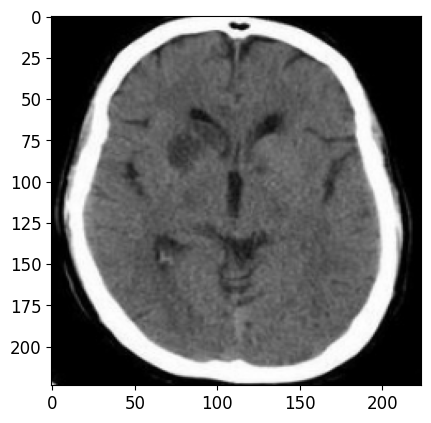

In [28]:
import numpy as np
for images_batch, labels_batch in dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Saving the model

In [29]:
import os
root_dir ="/"
dir_name ="models"
dir_path =os.path.join(root_dir,dir_name)
os.makedirs(dir_path,exist_ok=True)

In [30]:
model_version=max([int(i) for i in os.listdir("/models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [31]:
model.save("../adamTumor.h5")

In [32]:
import os
parent_dir=os.path.abspath(os.path.join(os.getcwd(),os.pardir))
new_file_path =os.path.join(parent_dir,"adamTumor.h5")
if os.path.isfile(new_file_path):
    print("The adamTumor.h5 file is located at :", new_file_path)

The adamTumor.h5 file is located at : c:\Users\akank\OneDrive\Desktop\adamTumor.h5
